## Training VAE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

base_dir = os.path.abspath('')
sys.path.append(os.path.join(base_dir, '../../../NNAero'))

from nnaero.models.vae import *
from nnaero.models.training.vae_trainer import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading Datasets

In [4]:
from torch.utils.data import DataLoader, TensorDataset

In [5]:
airfoil_df = pd.read_csv("/Data/sandeep/zMohit/AirFoil/dataset/airfoil/airfoil.csv")
airfoil_df.head(2)

,Unnamed: 0.1,Unnamed: 0,x,y,le_radius,le_angle,te_thickness,te_angle,max_curvature,max_dydx,smoothness,max_angle_change
0,0,air05_000001.dat,"[1.0, 0.9998494, 0.9993977, 0.9986452, 0.99759...","[0.0021193, 0.0021696, 0.0023205, 0.0025717, 0...",0.009239,169.346767,0.004239,4.066156,165.621277,13.992696,18.662465,12.571719
1,1,air05_000002.dat,"[1.0, 0.9998494, 0.9993977, 0.9986452, 0.99759...","[0.0019936, 0.0020424, 0.0021888, 0.0024327, 0...",0.009180,169.543298,0.003987,3.301608,131.508424,12.289509,17.116958,11.244668


In [6]:
def to_list(s):
    return np.fromstring(s).tolist()

airfoil_df["x"] = airfoil_df["x"].apply(eval)
airfoil_df["y"] = airfoil_df["y"].apply(eval)

x_common = np.array(airfoil_df["x"].iloc[0])
Y = np.array(airfoil_df["y"].tolist())

In [7]:
FEAT_SIZE = 257  # As per your code
model = VAE(feature_size=FEAT_SIZE, latent_size=32, encoder_config=[512,"tanh",256,"tanh",128,"tanh",64,"tanh"])

In [8]:
model

VAE(
  (encoder_body): BaseNetwork(
    (model): Sequential(
      (0): Linear(in_features=257, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Tanh()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): Tanh()
    )
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (decoder): BaseNetwork(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=257, bias=True)
      (5): Tanh()
    )
  )
)

In [ ]:



BATCH_SIZE = 64
dataset = TensorDataset(torch.tensor(Y, dtype=torch.float32))
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Create Trainer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
trainer = VAETrainer(model,
                    optimizer=optimizer,
                    kl_annealing=True,
                    kl_weight=5e-4,
                    warmup_epochs=30,
                    checkpoint_dir="vae_checkpoints",
                    device="cuda:6"
                     )

In [9]:
model

VAE(
  (encoder_body): BaseNetwork(
    (model): Sequential(
      (0): Linear(in_features=257, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
      (9): Tanh()
    )
  )
  (fc_mu): Linear(in_features=4, out_features=4, bias=True)
  (fc_logvar): Linear(in_features=4, out_features=4, bias=True)
  (decoder): BaseNetwork(
    (model): Sequential(
      (0): Linear(in_features=4, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=257, bias=True)
      (7): Tanh()
    )
  )
)

In [17]:
import os
EPOCHS = 500
PATIENCE = 50          
MIN_DELTA = 1e-6       # minimum change to qualify as improvement
CHECKPOINT_PATH = "vae_checkpoints/best_model.pth"

history = []
best_loss = float("inf")
epochs_no_improve = 0

for epoch in range(EPOCHS):
    metrics = trainer.train_epoch(train_loader, epoch)
    loss = metrics["loss"]
    history.append(metrics)

    print(f"Epoch {epoch} | " + " | ".join([f"{k}: {v:.6f}" for k, v in metrics.items()]))

    # --- Check for improvement ---
    if loss < best_loss - MIN_DELTA:
        best_loss = loss
        epochs_no_improve = 0

        # Save checkpoint
        # CHECKPOINT_PATH = trainer.save_checkpoint(epoch, name=CHECKPOINT_PATH)
        # os.makedirs(CHECKPOINT_PATH,exist_ok=True)
        
        os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': trainer.model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
        }, CHECKPOINT_PATH)

    else:
        epochs_no_improve += 1

    # --- Early stopping ---
    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered")
        break

# --- Load best model ---
checkpoint = torch.load(CHECKPOINT_PATH)
trainer.model.load_state_dict(checkpoint["model_state_dict"])
trainer.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

Epoch 0 | loss: 0.133765 | recon_loss: 0.133758 | kl_loss: 0.412186 | beta: 0.000017
Epoch 1 | loss: 0.041117 | recon_loss: 0.041092 | kl_loss: 0.751126 | beta: 0.000033
Epoch 2 | loss: 0.034359 | recon_loss: 0.034318 | kl_loss: 0.821744 | beta: 0.000050
Epoch 3 | loss: 0.026250 | recon_loss: 0.026163 | kl_loss: 1.305845 | beta: 0.000067
Epoch 4 | loss: 0.023789 | recon_loss: 0.023657 | kl_loss: 1.589819 | beta: 0.000083
Epoch 5 | loss: 0.022139 | recon_loss: 0.021956 | kl_loss: 1.830691 | beta: 0.000100
Epoch 6 | loss: 0.021074 | recon_loss: 0.020836 | kl_loss: 2.039905 | beta: 0.000117
Epoch 7 | loss: 0.020056 | recon_loss: 0.019759 | kl_loss: 2.228611 | beta: 0.000133
Epoch 8 | loss: 0.018341 | recon_loss: 0.017975 | kl_loss: 2.444707 | beta: 0.000150
Epoch 9 | loss: 0.015850 | recon_loss: 0.015399 | kl_loss: 2.704345 | beta: 0.000167
Epoch 10 | loss: 0.014498 | recon_loss: 0.013959 | kl_loss: 2.938727 | beta: 0.000183
Epoch 11 | loss: 0.013303 | recon_loss: 0.012685 | kl_loss: 3.08

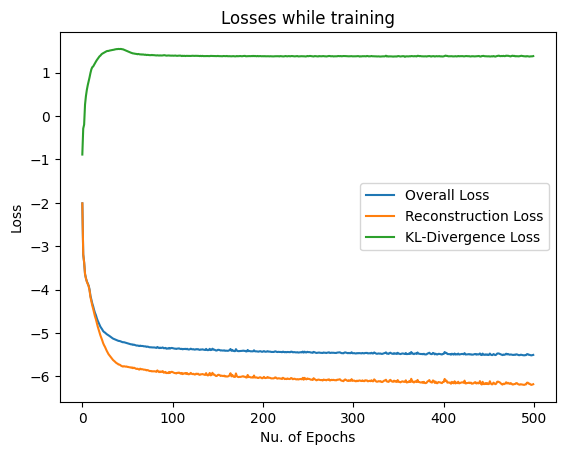

In [20]:
plt.plot(np.log([(a['loss']) for a in history]), label="Overall Loss")
plt.plot(np.log([(a['recon_loss']) for a in history]), label="Reconstruction Loss")
plt.plot(np.log([(a['kl_loss']) for a in history]), label="KL-Divergence Loss")
plt.title("Losses while training")
plt.xlabel("Nu. of Epochs")
plt.ylabel("Loss")
plt.legend()

### Sampling from VAE

In [21]:
plt.rcParams["figure.figsize"] = (3, 2)

#### Random Sampling

In [ ]:
@torch.no_grad()
def sample_vae(
    model,
    num_samples=16,
    device="cuda"
):
    model.eval()
    model.to(device)

    # Sample from standard normal latent space
    z = torch.randn(num_samples, model.latent_size, device=device)

    # Decode
    samples = model.decode(z)

    return samples

samples = sample_vae(trainer.model, num_samples=32, device="cuda")
print(samples.shape)

torch.Size([32, 257])


In [30]:
from nnaero.geometry.airfoil import *

In [31]:
coordinates = np.stack((x_common,samples[12,:].cpu().numpy()), axis=1)
coordinates.shape

(257, 2)

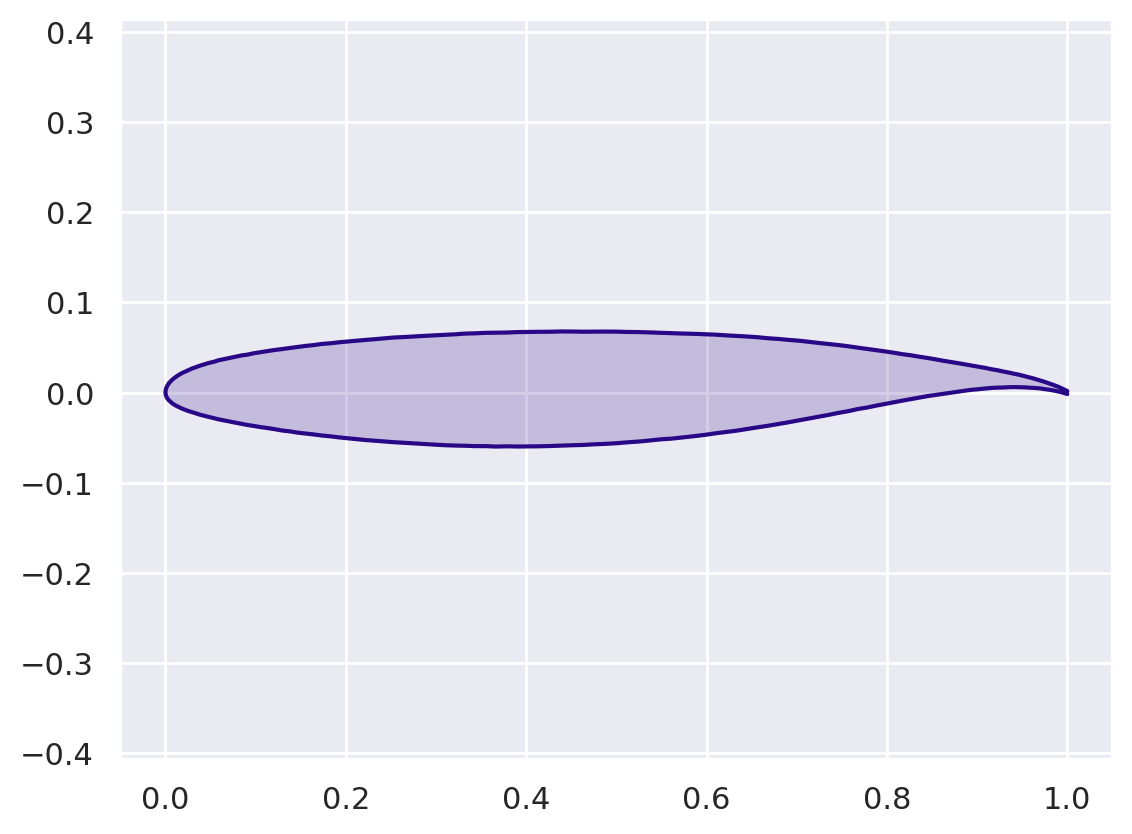

In [32]:
airfoil = Airfoil(coordinates=coordinates)
airfoil.draw(draw_markers=False, show=False)

#### Interpolating Sampling

In [33]:
@torch.no_grad()
def interpolate(
    model,
    x1,
    x2,
    steps=10,
    device="cuda"
):
    model.eval()
    x1, x2 = x1.to(device), x2.to(device)

    mu1, _ = model.encode(x1)
    mu2, _ = model.encode(x2)

    alphas = torch.linspace(0, 1, steps, device=device)
    z = torch.stack([(1-a)*mu1 + a*mu2 for a in alphas]).squeeze(1)

    return model.decode(z)


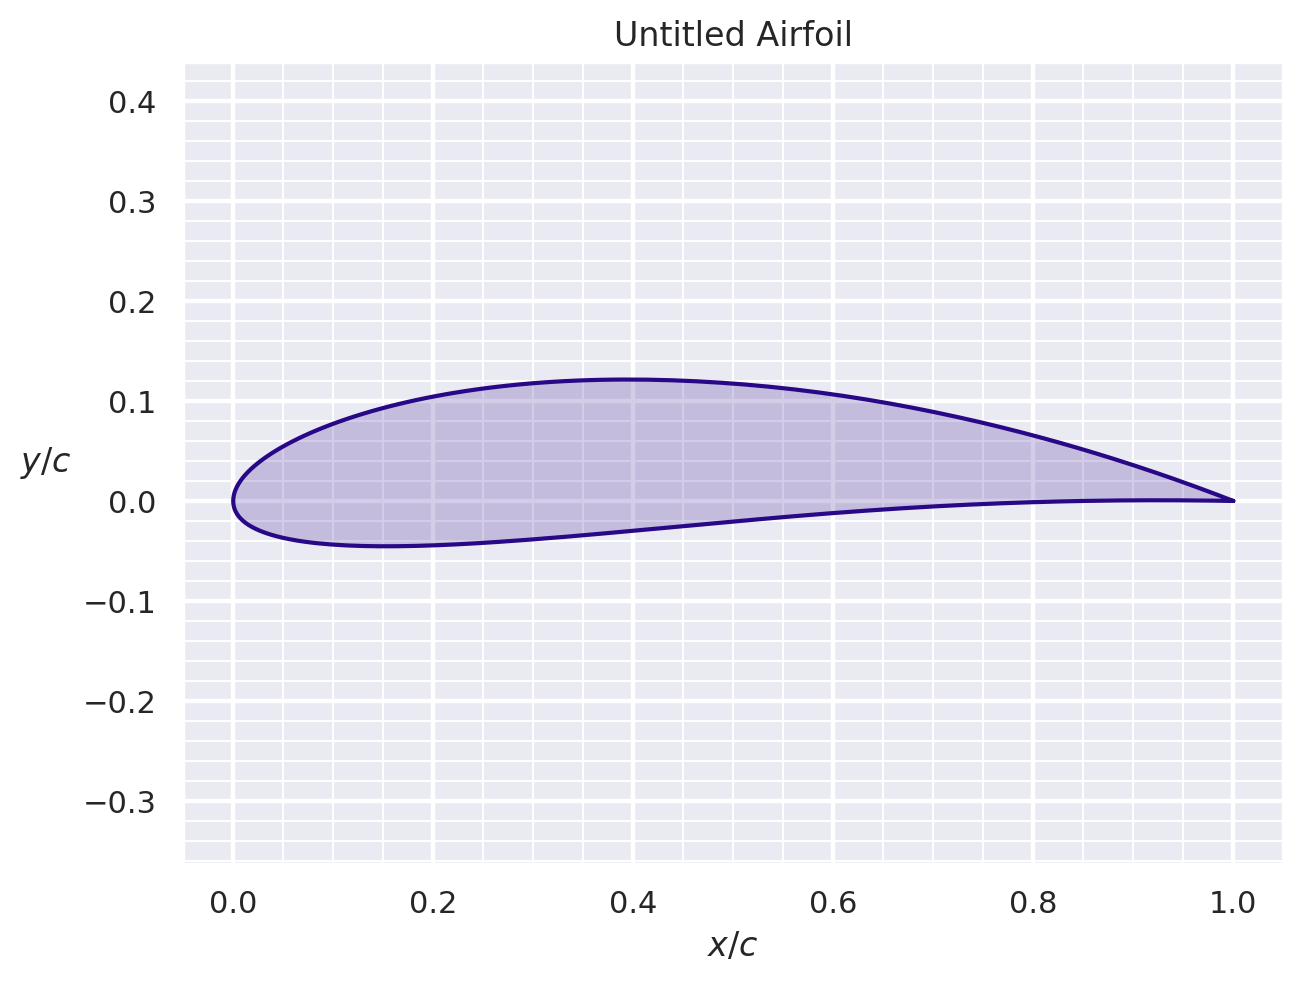

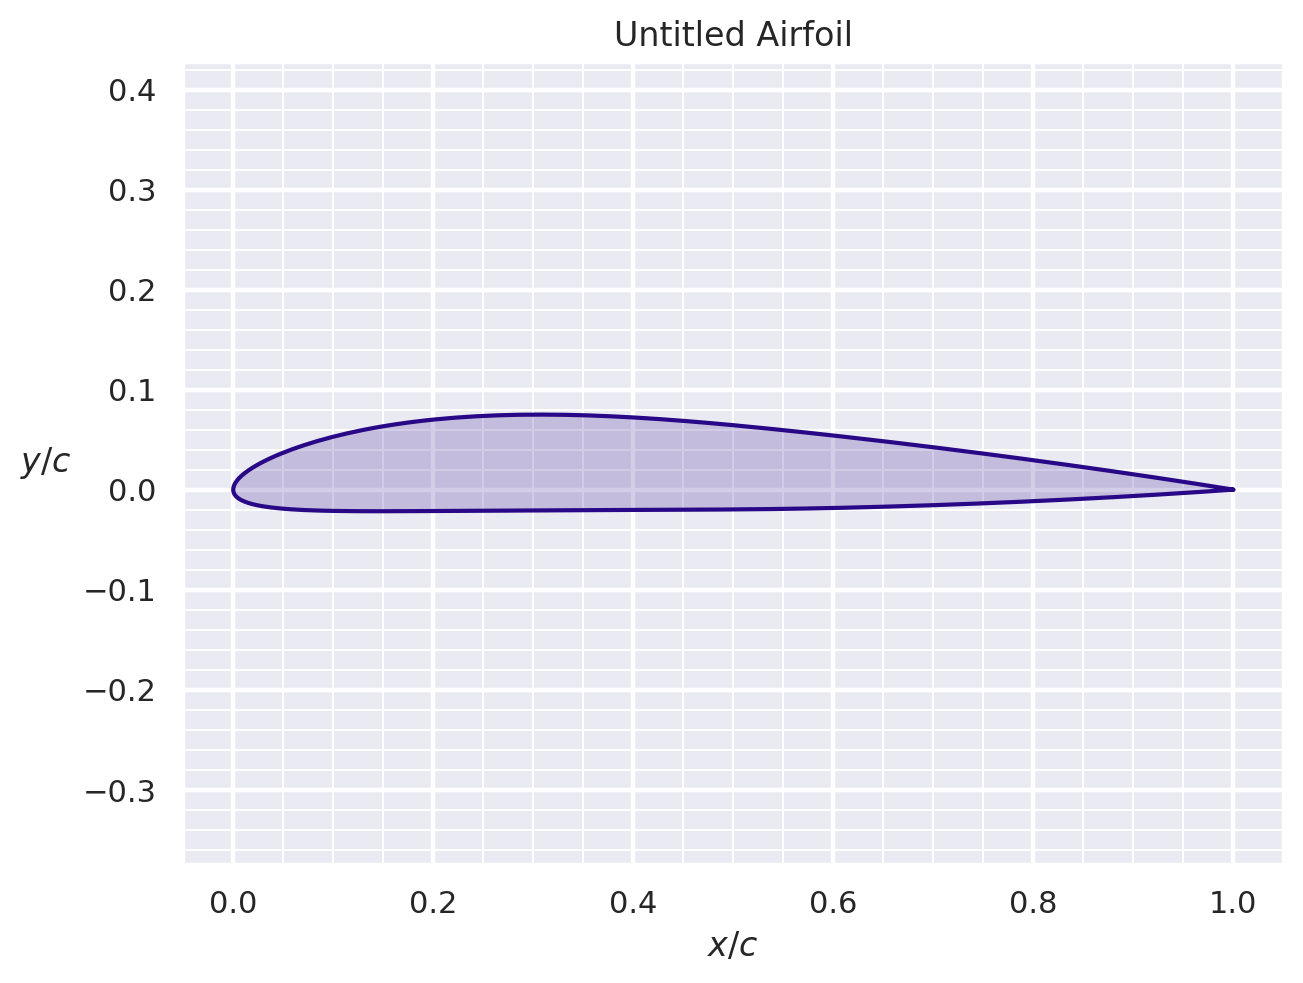

In [34]:
y_sample = airfoil_df.sample(2,random_state=203)["y"].to_list()
airfoil1 = Airfoil(coordinates=np.stack((x_common, y_sample[0]), axis=1))
airfoil2 = Airfoil(coordinates=np.stack((x_common, y_sample[1]), axis=1))
airfoil1.draw(draw_markers=False)
airfoil2.draw(draw_markers=False)

In [35]:
samples = interpolate(trainer.model, torch.tensor(y_sample[0]), torch.tensor(y_sample[1])).cpu().numpy()
sampled_airfoils = [Airfoil(coordinates=np.stack((x_common, samples[i]), axis=1)) for i in range(len(samples))]

In [36]:
plt.rcdefaults()

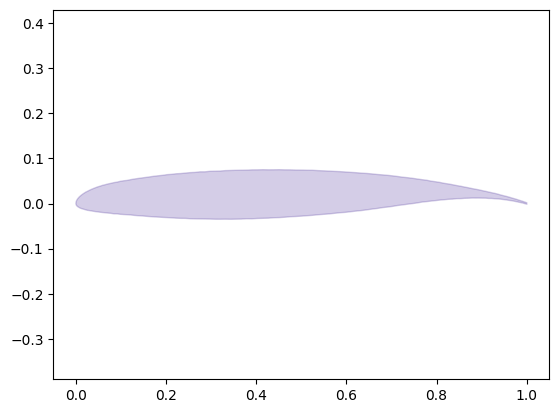

In [46]:
def draw(airfoil):
    x = np.reshape(np.array(airfoil.x()), -1)
    y = np.reshape(np.array(airfoil.y()), -1)
    color = "#280887"
    plt.fill(x, y, zorder=1, color=color, alpha=0.2)
    plt.axis("equal")
    plt.show()
    
draw(sampled_airfoils[7])

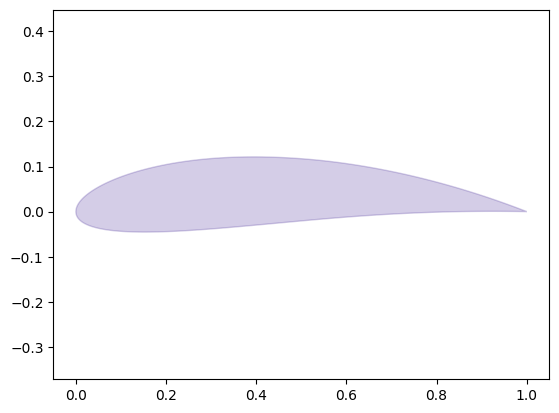

In [38]:
draw(airfoil1)

## How not to train VAEs

### Posterior Collapse